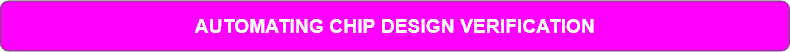

# > **SEMICONDUCTOR CHIPS**

**Semiconductor chips**, often referred to as microchips or integrated circuits (ICs), are the backbone of modern technology. They power virtually all electronic devices and systems.

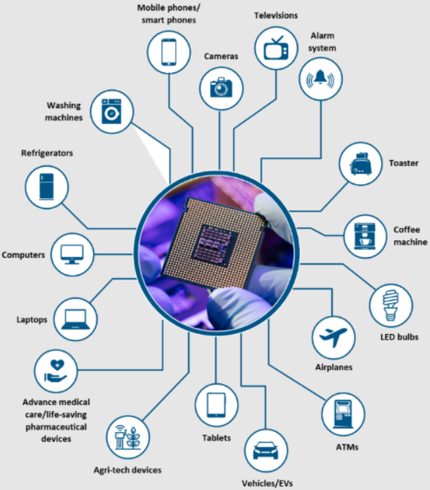

**CHIP DESIGN CYCLE:**

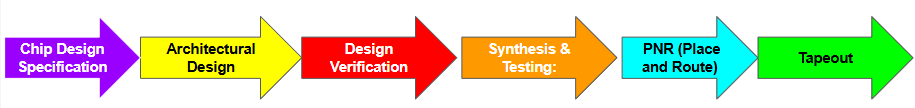

# > **CHIP DESIGN VERIFICATION**

**Out of all stages, design verification consumes most of the time. More the 50% of design cycle is spent in verification**

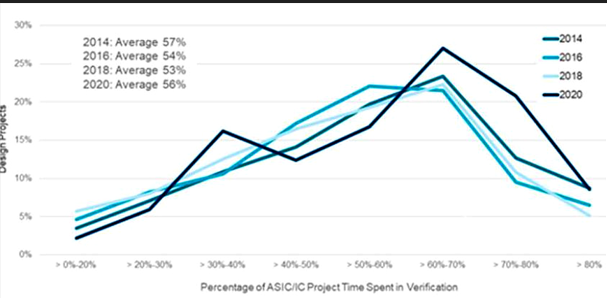

**Source:** https://www.researchgate.net/figure/Time-spent-on-verification-versus-total-design-time_fig6_355673232

**Why is Rigorous verification important?**

* Design verification involves simulating test cases on design to ensure the chip functions as intended, detecting and correcting design flaws before manufacturing.
 
* Manufacturing semiconductor chips is extremely expensive and time-consuming. Errors detected post-manufacturing lead to massive costs due to scrap, redesign, and re-fabrication. Verification reduces the risk of defects, minimizing financial loss and time delays.

* Many chips are used in mission-critical systems, such as medical devices, aircraft, and automotive safety systems. A faulty chip in such systems can have catastrophic consequences.


# > **LLM MODEL FOR DESIGN VERIFICATION**

**Thus I propose using LLM model to automate generating new test cases. This would greatly reduce time/resource needed to write test cases.
This would also create robust verification suite free from human prone error.**

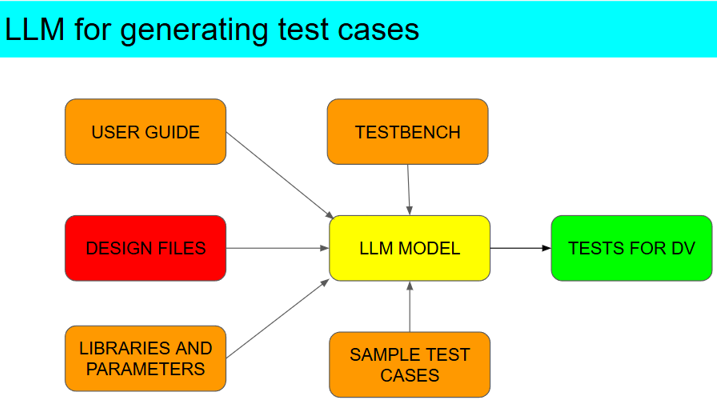
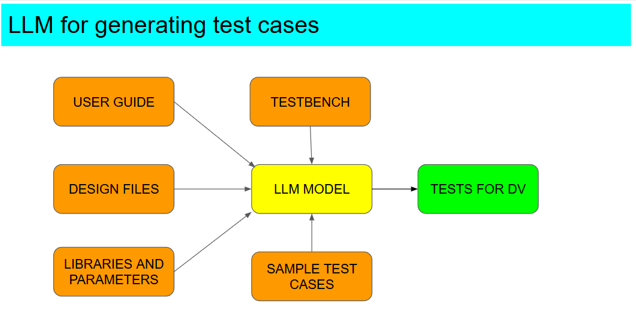
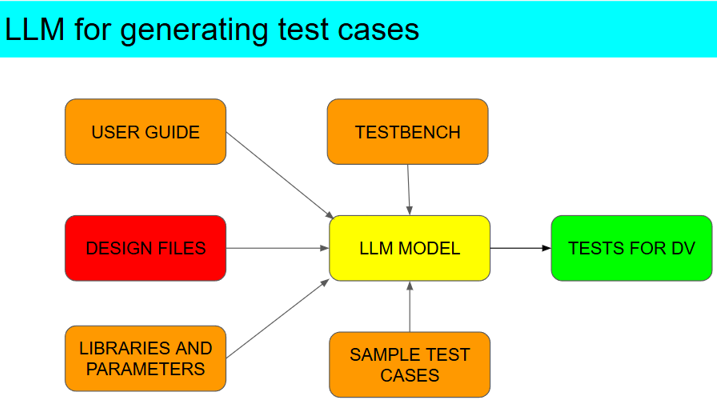

# > **Why GEMINI 1.5?**

The task requires synthesizing information from various types of context:

* **Design files:** Source code and configurations defining the SoC architecture.
* **User guide:** Detailed documentation providing design specifications and usage instructions.
* **Parameters and libraries:** Supporting files containing configurations and reusable components.
* **Test benches and sample test cases:** Existing test setups and examples to guide the generation of new test cases.

**Approximate token distribution for moderate chip design:**

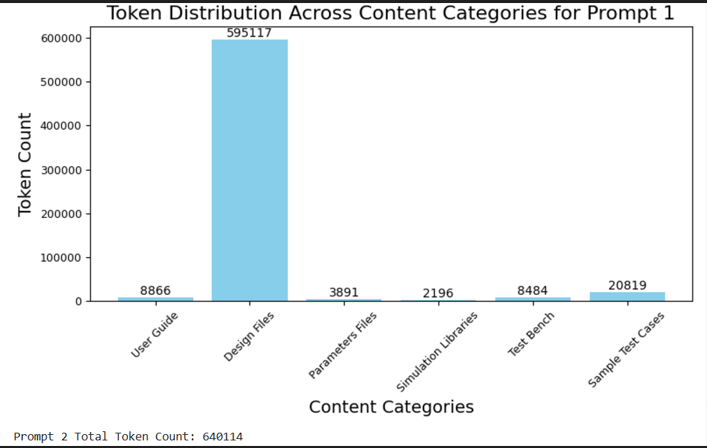

Each of these files contributes crucial context, but they collectively form a large corpus of information (totally add upto/more than 1M tokens). Traditional models with shorter context windows (32k–128k tokens) would struggle to process and integrate all of this data simultaneously, requiring preprocessing such as vector databases /RAG, which may lead to loss of context.

# > Why Vector Databases and RAG Doesn't Fit This Use Case:

**How Vector Databases and RAG Work:**

* **Vector Databases:** These are used to store and retrieve chunks of data based on their semantic embeddings. Queries retrieve the most relevant chunks based on similarity to the input.
* **RAG:** Combines retrieval from a vector database with a generative model to provide contextually relevant responses. The retrieved chunks are injected into the prompt for generating answers.


**Why It Doesn't Fit This Use Case:**

**Fragmentation of Context:** SoC design files, parameters, libraries and  sample tests often have logical sequences, highly structured information and inter-related dependencies between sections. Breaking them into smaller, retrievable chunks loses this continuity.

**Example:**

1. The behavior of a module might depend on global parameters defined in another file or section. A vector database may fail to retrieve all interdependent chunks cohesively.
2. Splits content (e.g., splitting a function definition across chunks) that should ideally be processed together.
3. If a test case for the WDT module requires retrieving clock-related parameters, but the retrieval mechanism misses them, the test case might be incomplete or incorrect.

**Redundancy in Repeated Queries:**

Verification test case generation often requires iterative prompting, where multiple iterations refine the test case or explore new scenarios.
With RAG, the same chunks might be retrieved repeatedly, leading to inefficiencies making the pipeline slower

**Additional Engineering Overhead**

* **Preprocessing:** Chunking, embedding, and storing the content in a vector database.
* **Query Engineering:** Designing and fine-tuning the retrieval mechanism.
* **Integration:** Combining retrieved chunks into a coherent prompt for the generative model.
* **Scalability:** Maintaining a vector database to stay in sync with design changes requires constant re-indexing and embedding updates.

**When RAG/Vector Databases Might Be Useful:**

If the dataset were extremely large (beyond the model's context window), and the task involved retrieving independent chunks (e.g., FAQs or isolated paragraphs). For highly unstructured datasets where logical dependencies are minimal.

**Conclusion:**

Gemini 1.5's long context window ensures that the entire context (user guide, design files, parameters, and test cases) can be processed in one go, maintaining the logical flow and delivering high-quality outputs without additional engineering effort.

# > **MULTI-SHOT PROMPTING**

With high quality sample test cases available, **multi-shot prompting** is used for this complex task to generate reliable and consistent output, leveraging Gemini 1.5's long context window.

**What is Multi-Shot Prompting?**

Multi-shot prompting involves providing multi examples of similar tasks or desired outputs in the prompt. These examples act as demonstrations that guide the model to understand the task requirements and produce outputs consistent with the provided patterns.

**How Multi-Shot Prompting Helps in This Use Case?**

Providing multiple examples of well-structured verification test cases helps the model:

* Learn the structure of the test cases (e.g., module initialization, test scenarios, expected outcomes).
* Identify gaps in existing test cases and extrapolate to cover untested scenarios.
* Relevant scenarios that align with the design specifications and system constraints.
* Allows quick iterations and adaptability.
* No need of fine-tuning the model on domain-specific data, saving time and computational resources.

**Thus for all the above explanations, gemini 1.5's ability to handle up to 2 million tokens makes the perfect choice**

In [ ]:
# Install necessary libraries
!pip install python-docx
!pip install requests
!pip install matplotlib

# Import libraries
import os
import json
import requests
from docx import Document
import os
import time
from pathlib import Path
import shutil
import requests
import IPython.display
import git
import google.generativeai as genai
from kaggle_secrets import UserSecretsClient
from IPython.display import display
import matplotlib.pyplot as plt

# > **CHIP DESIGN CHOOSEN: Wujian100_open**

Wujian100_open is an open-source microcontroller unit (MCU) system-on-chip (SoC) platform developed by T-Head, a subsidiary of Alibaba Group.

**Complete code:**
https://github.com/XUANTIE-RV/wujian100_open/tree/master

In [ ]:
# Define the base directory for the Wujian100 Open Master project files (cloned from github)
BASE_DIR = '/kaggle/input/wujian100/wujian100_open-master/'

# Define the path to the user guide document
USER_GUIDE_PATH = os.path.join(BASE_DIR, 'doc', 'wujian100_open Userguide v1.0.docx')  # Path to the user guide documentation

# Define the directory containing the SoC design files
DESIGN_FILES_DIR = os.path.join(BASE_DIR, 'soc')  # Main directory for SoC design files

# Define the directory containing the parameter files
PARAMS_DIR = os.path.join(DESIGN_FILES_DIR, 'params')  # Subdirectory for design parameters

# Define the directory containing simulation libraries
SIM_LIB_DIR = os.path.join(DESIGN_FILES_DIR, 'sim_lib')  # Subdirectory for simulation libraries

# Define the directory containing test benches
TEST_BENCH_DIR = os.path.join(BASE_DIR, 'tb')  # Directory for test bench files

# Define the directory containing sample test cases
SAMPLE_TEST_CASES_DIR = os.path.join(BASE_DIR, 'case')  # Directory for sample test cases

In [ ]:
# Function to read and extract text from a .docx file
def read_docx(file_path):
    # Load the .docx file using the Document class from the python-docx library
    doc = Document(file_path)
    
    # Initialize a list to hold the text of each paragraph
    full_text = []
    
    # Loop through all paragraphs in the document
    for para in doc.paragraphs:
        # Append the text of each paragraph to the list
        full_text.append(para.text)
    
    # Join all the text with newlines to return as a single string
    return '\n'.join(full_text)


In [ ]:
import os

def read_all_files(directory):
    # Initialize a list to store the content of all files
    file_contents = []

    # Walk through the directory tree
    for root, dirs, files in os.walk(directory):
        for file in files:
            # Construct the full file path
            file_path = os.path.join(root, file)
            try:
                # Check if the file is a Word document
                if file.endswith('.docx'):
                    # Use a custom function (read_docx) to read .docx files
                    content = read_docx(file_path)

                # Check if the file is a Python, Verilog, or SystemVerilog file
                elif file.endswith('.py') or file.endswith('.v') or file.endswith('.sv'):
                    # Open and read the file as plain text
                    with open(file_path, 'r', encoding='utf-8') as f:
                        content = f.read()

                # For all other file types, read them as plain text
                else:
                    with open(file_path, 'r', encoding='utf-8') as f:
                        content = f.read()

                # Append the filename and content to the list
                file_contents.append({'filename': file, 'content': content})
            
            except Exception as e:
                # Handle errors gracefully and print the file path that caused the error
                print(f"Error reading {file_path}: {e}")
    
    # Return the list of file contents
    return file_contents

# > **PREPARE PROMPT**

In [ ]:
# This function will structure the cached sections of input content into a prompt suitable for the model
def prepare_prompt_with_cache(all_contents, design_files_required, task):
    # Use cache for user guide
    user_guide = get_cached_content("user_guide", lambda: all_contents['user_guide'])

    # Prepare design files (only required ones, use cache per file)
    design_files_content = ""
    for file in all_contents['design_files']:
        if file['filename'] in design_files_required:
            cache_key = f"design_file_{file['filename']}"
            content = get_cached_content(cache_key, lambda: file['content'])
            design_files_content += f"File: {file['filename']}\nContent:\n{content}\n\n"

    # Use cache for parameters
    parameters_content = get_cached_content(
        "parameters", 
        lambda: "\n\n".join(
            f"File: {file['filename']}\nContent:\n{file['content']}" for file in all_contents['params_files']
        )
    )

    # Use cache for simulation libraries
    sim_lib_content = get_cached_content(
        "simulation_libraries", 
        lambda: "\n\n".join(
            f"File: {file['filename']}\nContent:\n{file['content']}" for file in all_contents['sim_lib_files']
        )
    )

    # Use cache for test bench
    test_bench_content = get_cached_content(
        "test_bench",
        lambda: "\n\n".join(
            f"File: {file['filename']}\nContent:\n{file['content']}" for file in all_contents['test_bench']
        )
    )

    # Use cache for sample test cases
    sample_cases_content = get_cached_content(
        "sample_test_cases",
        lambda: "\n\n".join(
            f"File: {case['filename']}\nContent:\n{case['content']}" for case in all_contents['sample_test_cases']
        )
    )

    # Combine all parts into the final prompt
    prompt = (
        f"### User Guide:\n{user_guide}\n\n"
        f"### Design Files:\n{design_files_content}\n\n"
        f"### Parameters:\n{parameters_content}\n\n"
        f"### Simulation Libraries:\n{sim_lib_content}\n\n"
        f"### Test Bench:\n{test_bench_content}\n\n"
        f"### Sample Test Cases:\n{sample_cases_content}\n\n"
        f"{task}"
    )

    return prompt

# > CONTEXT CACHING

**What is Context Caching?**

Context caching is a computational strategy used to improve efficiency by storing and reusing portions of context or data that are repeatedly used in tasks involving generative AI models.

**How it helps in this use case?**

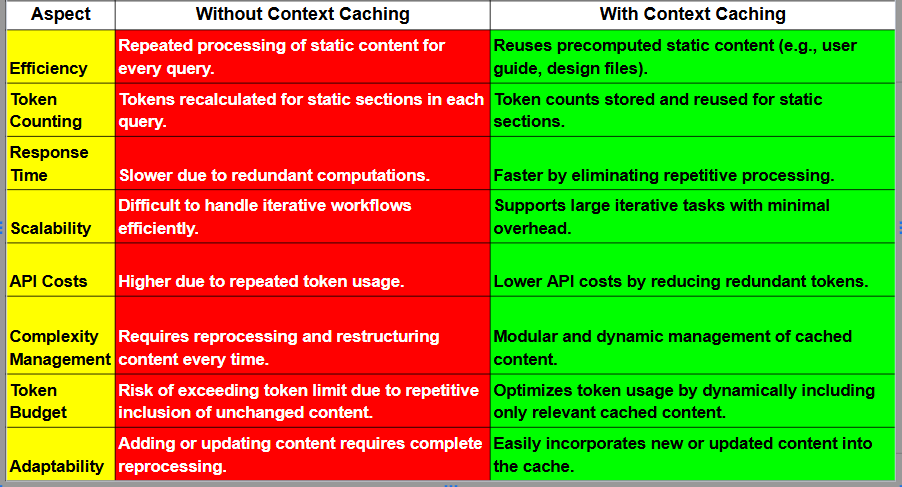

In [ ]:
# Key Idea:Cache static sections (e.g., user guide, design files) and reuse them across multiple prompts without recalculating 
#          token counts or re-processing content.

# Initialize a cache dictionary to store processed content
context_cache = {}

# Function to retrieve from cache or process if not cached
def get_cached_content(key, process_function, *args):
    if key in context_cache:
        return context_cache[key]
    else:
        content = process_function(*args)
        context_cache[key] = content
        return content

# > COUNT TOKENS

In [ ]:
#Function to Count Tokens
def count_tokens(text):
    response = model.count_tokens([text])
    return response.total_tokens

In [ ]:
#Count Tokens for Each Cached Content Category in given prompt
def count_token_prompt_with_cache(all_contents, design_files_required):
    # Initialize a dictionary to hold token counts
    token_counts = {}

    # Count tokens for user guide using cache
    user_guide_tokens = count_tokens(get_cached_content("user_guide", lambda: all_contents['user_guide']))
    token_counts['User Guide'] = user_guide_tokens

    # Count tokens for design files using cache
    design_tokens = 0
    for file in all_contents['design_files']:
        if file['filename'] in design_files_required:
            cache_key = f"design_file_{file['filename']}"
            design_tokens += count_tokens(get_cached_content(cache_key, lambda: file['content']))
    token_counts['Design Files'] = design_tokens

    # Count tokens for parameters using cache
    params_tokens = count_tokens(get_cached_content(
        "parameters", 
        lambda: "\n\n".join(f"File: {file['filename']}\nContent:\n{file['content']}" for file in all_contents['params_files'])
    ))
    token_counts['Parameters Files'] = params_tokens

    # Count tokens for simulation libraries using cache
    sim_lib_tokens = count_tokens(get_cached_content(
        "simulation_libraries", 
        lambda: "\n\n".join(f"File: {file['filename']}\nContent:\n{file['content']}" for file in all_contents['sim_lib_files'])
    ))
    token_counts['Simulation Libraries'] = sim_lib_tokens

    # Count tokens for test bench using cache
    test_bench_tokens = count_tokens(get_cached_content(
        "test_bench", 
        lambda: "\n\n".join(f"File: {file['filename']}\nContent:\n{file['content']}" for file in all_contents['test_bench'])
    ))
    token_counts['Test Bench'] = test_bench_tokens

    # Count tokens for sample test cases using cache
    sample_cases_tokens = count_tokens(get_cached_content(
        "sample_test_cases", 
        lambda: "\n\n".join(f"File: {case['filename']}\nContent:\n{case['content']}" for case in all_contents['sample_test_cases'])
    ))
    token_counts['Sample Test Cases'] = sample_cases_tokens

    return token_counts


In [ ]:
# Read user guide for context caching
# Load the content of the user guide
user_guide_content = read_docx(USER_GUIDE_PATH)

# Read design files
design_files = read_all_files(DESIGN_FILES_DIR)

# Read parameters files
params_files = read_all_files(PARAMS_DIR)

# Read simulation library files
sim_lib_files = read_all_files(SIM_LIB_DIR)

# Read test bench files
test_bench_files = read_all_files(TEST_BENCH_DIR)

# Read sample test cases
sample_test_cases = read_all_files(SAMPLE_TEST_CASES_DIR)

# Aggregate all the loaded content into a dictionary for easy access and reference in the pipeline.
all_contents = {
    'user_guide': user_guide_content,
    'design_files': design_files,
    'params_files': params_files,
    'sim_lib_files': sim_lib_files,
    'test_bench': test_bench_files,
    'sample_test_cases': sample_test_cases
}

# > **LLM CONFIGURATION**

In [ ]:
# Initialize the UserSecretsClient to retrieve securely stored secrets
user_secrets = UserSecretsClient()

# Retrieve the API key for the GEMINI AI Studio from user secrets
ai_studio_token = user_secrets.get_secret("GEMINI_API_KEY")

# Configure the GenAI client with the retrieved API key for authentication
genai.configure(api_key=ai_studio_token)

In [ ]:
# Define the configuration for the text generation model
generation_config = {
  "temperature": 1,  # Controls the randomness of the output; higher value = more random responses
  "top_p": 0.95,  # Nucleus sampling: considers the top 95% of probability mass for the next token
  "max_output_tokens": 20000,  # Sets the maximum number of tokens the model can generate in a response
  "response_mime_type": "text/plain",  # Specifies the MIME type of the response, here plain text
}

# Initialize the Generative AI model using the configuration
model = genai.GenerativeModel(
  model_name="gemini-1.5-flash",  # Specifies the variant of the Gemini 1.5 model to use
  # model_name="gemini-1.5-pro-002",  # (Optional) Uncomment to use a different variant of the model
  generation_config=generation_config,  # Pass the configuration defined above
)


# > **DEMONSTRATION:** 

**Generate 2 test cases for different blocks with 2 different prompts**

# > **PROMPT 1:**

In [ ]:
#Not all design files are required. Depending on the test cases needed, proivde only required models for context
design_files_required = ["E902_20191018.v", "core_top.v", "pdu_top.v", "retu_top.v", "smu_top.v", "ls_sub_top.v", "apb0_sub_top.v", 
                         "apb1_sub_top.v", "ahb_matrix_top.v", "common.v", "aou_top.v", "wdt.v"]

#Describe the testcase required
task = """### Task:\nBased on the above information, generate a new verification test case for wdt that existing sample test cases has not tested.\n
        Add inline comments for the test case.\n
        Also document the intention of the test case with explanation, expected output(if applicable) in multiline comment."""

# Prepare the prompt for the model
prompt_1 = prepare_prompt_with_cache(all_contents, design_files_required, task)

# Combine the prepared prompt into a list of contents for processing
contents = [prompt_1]

In [ ]:
# Get token counts for each content
token_counts = count_token_prompt_with_cache(all_contents, design_files_required)

# Plot the token distribution
categories = list(token_counts.keys())
counts = list(token_counts.values())

plt.figure(figsize=(8, 5))
bars = plt.bar(categories, counts, color='skyblue')

# Add token count labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 50, yval, ha='center', va='bottom')

plt.xlabel('Content Categories', fontsize=14)
plt.ylabel('Token Count', fontsize=14)
plt.title('Token Distribution Across Content Categories for Prompt 1', fontsize=16)
plt.xticks(rotation=45, fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.show()

# Count the tokens in the contents to ensure it stays within the model's token limit
response = model.count_tokens(contents)
print(f"Prompt 1 Total Token Count: {response.total_tokens}")

In [ ]:
# Generate responses from the model based on the provided content
responses = model.generate_content(contents)

# Print the generated test case
print(f"Test case 1:")
for response in responses:
    print(response.text)

# > **PROMPT 2:**

In [ ]:
#Not all design files are required. Depending on the test cases needed, proivde only required models for context
design_files_required = ["E902_20191018.v", "core_top.v", "pdu_top.v", "retu_top.v", "smu_top.v", "ls_sub_top.v", "apb0_sub_top.v", 
                         "apb1_sub_top.v", "ahb_matrix_top.v", "common.v", "aou_top.v", "usi0.v", "usi0.v"]

#Describe the testcase required
task = """### Task:\nBased on the above information, generate a new verification test case for USI SPI configured as slave mode, where USI0 receives data.\n
        Add inline comments for the test case.\n
        Also document the intention of the test case with explanation, expected output(if applicable) in multiline comment."""

# Prepare the prompt for the model
# This function will structure the input content into a prompt suitable for the model
prompt_2 = prepare_prompt_with_cache(all_contents, design_files_required, task)

# Combine the prepared prompt into a list of contents for processing
contents = [prompt_2]

In [ ]:
# Get token counts for each content
token_counts = count_token_prompt_with_cache(all_contents, design_files_required)

# Plot the token distribution
categories = list(token_counts.keys())
counts = list(token_counts.values())

plt.figure(figsize=(8, 5))
bars = plt.bar(categories, counts, color='skyblue')

# Add token count labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 50, yval, ha='center', va='bottom')

plt.xlabel('Content Categories', fontsize=14)
plt.ylabel('Token Count', fontsize=14)
plt.title('Token Distribution Across Content Categories for Prompt 1', fontsize=16)
plt.xticks(rotation=45, fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.show()

# Count the tokens in the contents to ensure it stays within the model's token limit
response = model.count_tokens(contents)
print(f"Prompt 2 Total Token Count: {response.total_tokens}")

In [ ]:
# Generate responses from the model based on the provided content
responses = model.generate_content(contents)

# Print the generated test case
print(f"Test case 2:")
for response in responses:
    print(response.text)

# > **HIGH QUALITY OUTPUT**

As shown above, generated test cases are of high quality complying with best practices. They got **test intention, expected output, inline comments and well structured**. These are important to track test coverage, readability and for reusability(say to use them for another project).

These are not consistently found in human created test cases


Note: **Demonstrated example use tokens in the range of ~600000. More complex chip design requires upto 2M tokens.**